# FIFA 2020 Player Data Analysis

In [1]:
# loading packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics, svm
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

## Data Importing & Cleaning

In [2]:
# loading data
url = 'https://raw.githubusercontent.com/dR3AmZZ/fifa-2020-analysis/main/players_20.csv'
original_data = pd.read_csv(url)

In [3]:
# drop useless columns
drop1_columns = ['sofifa_id', 'player_url', 'long_name', 'player_tags', 'player_traits', 
                 'real_face', 'nation_jersey_number', 'team_jersey_number',
                 'loaned_from', 'joined', 'contract_valid_until','body_type']
fixed1_Data = original_data.drop(drop1_columns, axis=1)

In [4]:
# drop position ability(duplicated and will affect the final result)
drop2_columns = fixed1_Data.columns[-26:]
fixed2_Data = fixed1_Data.drop(drop2_columns, axis=1)

In [5]:
# drop duplicated columns
drop3_columns = ['wage_eur', 'team_position', 'release_clause_eur', 'nation_position', 'gk_diving',
                 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'pace', 
                 'shooting', 'passing', 'dribbling', 'defending', 'physic']
fixed3_Data = fixed2_Data.drop(drop3_columns, axis=1)

In [6]:
# split player_positions and choose the first position as primary position
new = fixed3_Data['player_positions'].str.split(',', expand=True)
fixed3_Data['Position'] = new[0]
position_data = fixed3_Data.drop('player_positions', axis=1)

In [7]:
# split work_Rate 
work_Rate = fixed3_Data['work_rate'].str.split('/', expand=True)
position_data['Attack_workrate'] = work_Rate[0]
position_data['Defend_workrate'] = work_Rate[1]
position_data = position_data.drop('work_rate', axis=1)

In [8]:
# narrow down positions: defender
defender = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']
defender_data = position_data[position_data['Position'].isin(defender)].copy()
defender_data['Positon_General'] = 'Defender'
defender_data.shape

(5938, 52)

In [9]:
# midfileder
midfileder = ['LCM', 'LM', 'RDM', 'CAM', 'RAM', 'RCM', 'CM', 'CDM', 'RM', 'LAM', 'LDM']
midfileder_data = position_data[position_data['Position'].isin(midfileder)].copy()
midfileder_data['Positon_General'] = 'Midfileder'
midfileder_data.shape

(6862, 52)

In [10]:
# attacker
attacker = ['ST', 'CF', 'LW', 'RW']
attacker_data = position_data[position_data['Position'].isin(attacker)].copy()
attacker_data['Positon_General'] = 'Attacker'
attacker_data.shape

(3442, 52)

In [11]:
# goal keeper
gk_data = position_data[position_data['Position'] == 'GK'].copy()
gk_data['Positon_General'] = 'GK'
gk_data.shape

(2036, 52)

In [12]:
# union all four group of data
general_data = pd.concat([defender_data, midfileder_data, attacker_data, gk_data])

In [13]:
# check missing data
general_data.isna().sum().sum()

0

In [14]:
# check duplicated data
general_data.duplicated().sum()

0

In [15]:
# numerlize categorical data
# Rate: low, medium, high: 0, 1, 2
# foot: left, right: 1, 0
# Positon_General: GK:0, Defender:1, Midfileder:2, Attacker:3 (One of the target)
general_data['Attack_workrate'] = general_data['Attack_workrate'].map({'Low':0, 'Medium':1, 'High':2})
general_data['Defend_workrate'] = general_data['Defend_workrate'].map({'Low':0, 'Medium':1, 'High':2})
general_data['Positon_General'] = general_data['Positon_General'].map({'GK':0, 'Defender':1, 'Midfileder':2, 'Attacker':3})

In [16]:
# one hot encoding for preferred_foot
onehot_data = pd.get_dummies(general_data[['preferred_foot']])

In [17]:
data = pd.concat([general_data, onehot_data], axis=1)
data = data.drop(['preferred_foot','Position'], axis=1)
data = data.reset_index(drop=True)

In [18]:
# make copy of original data
df = data.copy()

# Regression 

## Train Test split

In [20]:
# select numerical columns and store data in df_regression
num_col = df.select_dtypes(include=np.number).columns.tolist()
df_regression = df[num_col]

In [23]:
# train test split
X = df_regression[num_col].drop(['value_eur','overall','potential'],axis=1)
Y = df_regression['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=1)

In [24]:
# Standardization to eliminate scale effect
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

## ElasticNet Regression

In [26]:
from sklearn.linear_model import ElasticNet

In [36]:
EN = ElasticNet(random_state=0, max_iter=10000)
param_grid = {'l1_ratio':[.1,.5,.7,.9,.95,.99,1]}
grid = GridSearchCV(EN, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000, random_state=0),
             param_grid={'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='r2')

In [38]:
print('The r square of elasticnet regression: {}'.format(grid.best_score_))
print('The best parameter of elasticnet regression: {}'. format(grid.best_params_))

The r square of elasticnet regression: 0.5643231483446363
The best parameter of elasticnet regression: {'l1_ratio': 1}


In [39]:
#extract best estimator
el_best = grid.best_estimator_

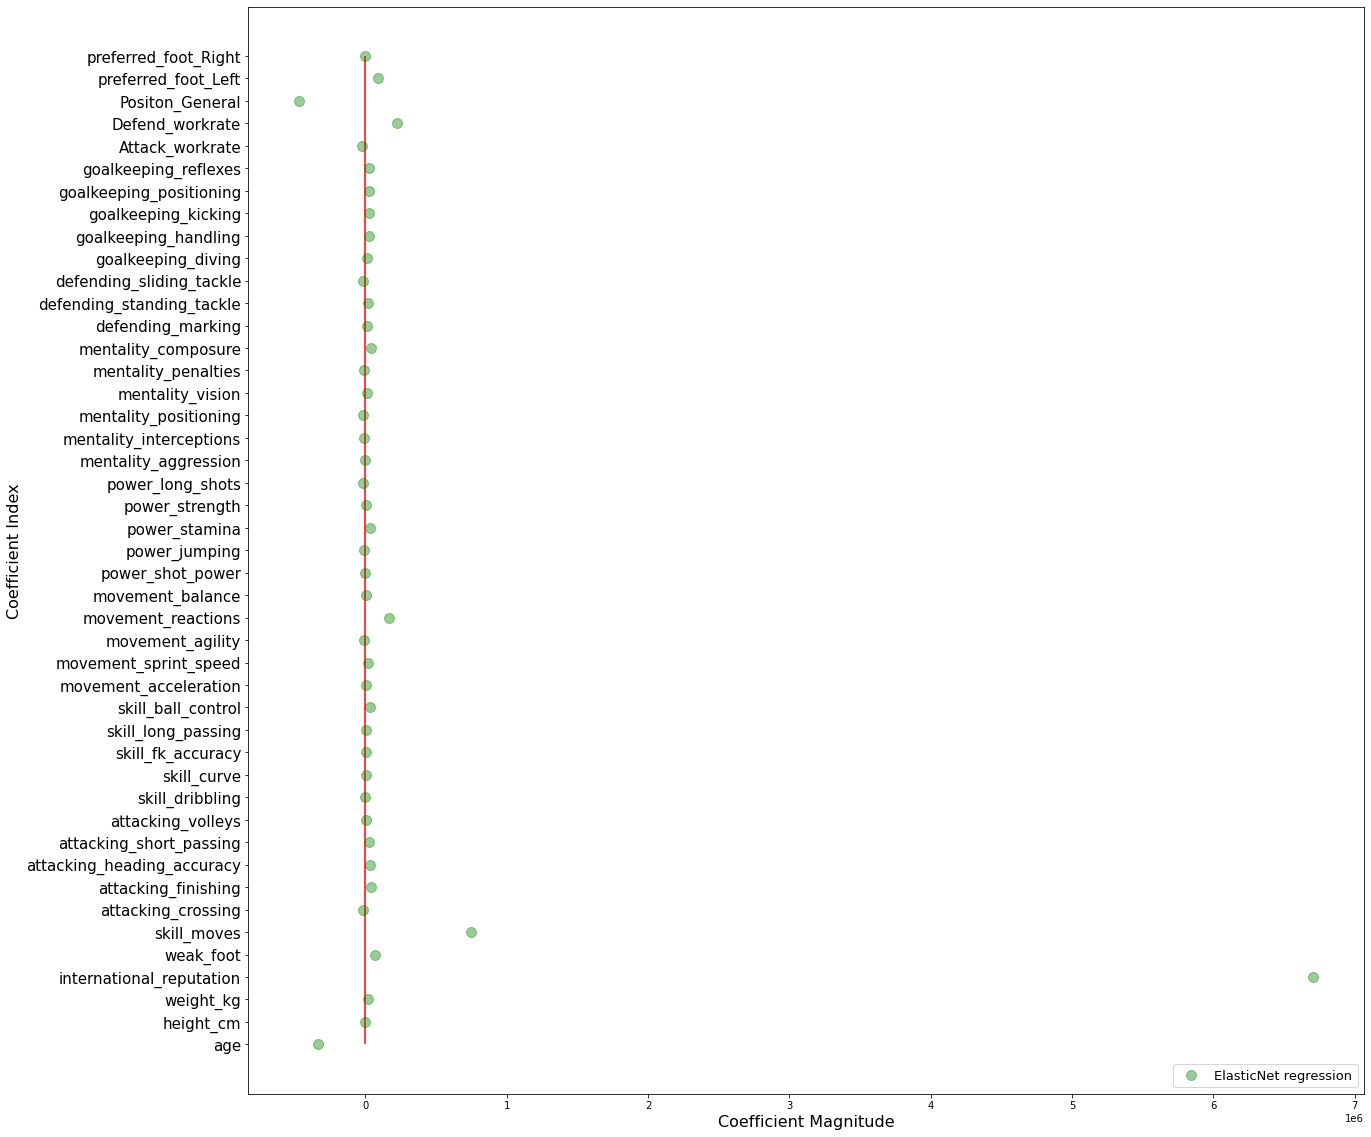

In [50]:
# visualization coefficients of elastice net
coef_df = pd.DataFrame(list(zip(X.columns,el_best.coef_)), columns=['Attributes', 'Coefficients'])
plt.figure(figsize=(20,20))
plt.plot(coef_df['Coefficients'],coef_df['Attributes'],alpha=0.4,linestyle='none',marker='o',markersize=10,color='green',label='ElasticNet regression')
plt.yticks(fontsize=15)
plt.xlabel('Coefficient Magnitude',fontsize=16)
plt.ylabel('Coefficient Index',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.vlines(0,ymin = 0,ymax=44,color='r')
plt.show()

## Random Forest Regression

In [56]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 50, stop = 150, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [59]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_cv = RandomizedSearchCV(estimator = rf, param_distributions = rf_grid, n_iter = 100, cv = 3, verbose=2, random_state=42,scoring='r2', n_jobs = -1)
# Fit the random search model
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, scoring='r2', verbose=2)

In [62]:
#extract model with the best performance
rf_cv.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [64]:
# Return the coefficient of determination R^2 of the prediction.
rf_cv.best_score_

0.8859002038493559

In [100]:
rfr_model = rf_cv.best_estimator_
rf_pred = rfr_model.predict(X_test)
# print test error in rmse
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, rf_pred, squared=True))

2997075918164.8247


In [108]:
# extract feature importances
fi_df = pd.DataFrame(rfr_model.feature_importances_, columns=['Importances'])
fi_df['feature_name'] =  X.columns
fi_df.sort_values(by=['Importances'], ascending=True, inplace=True)
fi_df_new = fi_df[fi_df['Importances']>0.005]

<Figure size 1440x720 with 0 Axes>

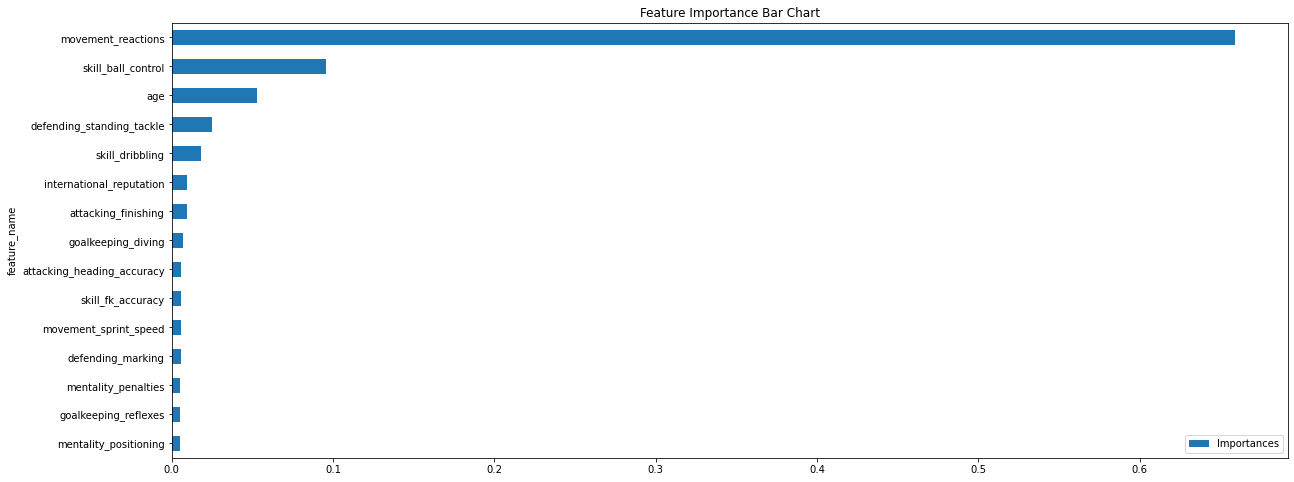

In [109]:
plt.figure(figsize=(20,10))
fi_df_new.plot.barh(x='feature_name', 
               y ='Importances',
               figsize=(20,8), 
               title='Feature Importances', 
               fontsize=10)
plt.title('Feature Importance Bar Chart')
plt.show()

In [104]:
print('R^2:',metrics.r2_score(y_test, rf_pred))
print('MAE:',metrics.mean_absolute_error(y_test,rf_pred))
print('MSE:',metrics.mean_squared_error(y_test, rf_pred, squared=True))
print('RMSE:',metrics.mean_squared_error(y_test, rf_pred, squared=False))

R^2: 0.9090911178749796
MAE: 640843.3847379321
MSE: 2997075918164.8247
RMSE: 1731206.492064082


In [105]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_pred, squared=False))

In [106]:
rf_pred

array([3902976.58730159, 6785303.17460318, 3433677.34487734, ...,
        310229.47330447, 4483166.63059163, 1112259.42460318])

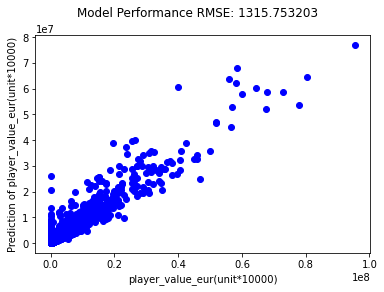

In [107]:
plt.plot(y_test, rf_pred, 'bo')
plt.xlabel('player_value_eur(unit*10000)')
plt.ylabel('Prediction of player_value_eur(unit*10000)')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

# Classification

## Data Preparation

In [135]:
#train, test set split
#training_list is required for classifier function 
training_list = df_regression.iloc[:,10:].columns.tolist()

In [136]:
training_list.append('height_cm')
training_list.append('weight_kg')
training_list.append('age')

In [137]:
training_set = df_regression[training_list]
training_set = training_set.reset_index(drop = True)

In [138]:
training_set

,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,...,goalkeeping_positioning,goalkeeping_reflexes,Attack_workrate,Defend_workrate,Positon_General,preferred_foot_Left,preferred_foot_Right,height_cm,weight_kg,age
0,52,86,78,45,70,60,70,81,76,74,...,11,11,1,1,1,0,1,193,92,27
1,22,83,71,14,69,28,28,63,71,69,...,13,5,1,2,1,0,1,187,89,28
2,33,83,65,45,59,60,31,65,61,61,...,4,3,1,2,1,1,0,187,85,34
3,63,92,80,69,65,74,72,83,83,74,...,7,11,2,1,1,0,1,184,82,33
4,65,85,83,57,63,58,43,81,82,48,...,15,8,2,1,1,0,1,194,85,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,5,13,12,7,14,13,11,17,18,15,...,48,53,1,1,0,0,1,188,81,25
18274,6,13,21,9,8,14,13,18,12,29,...,49,51,1,1,0,0,1,185,65,17
18275,10,15,35,10,25,19,11,29,20,31,...,48,51,1,1,0,0,1,182,78,19
18276,7,11,19,7,10,13,10,18,12,27,...,47,51,1,1,0,0,1,185,71,17


In [139]:
#train, test set is required for classifier function 
Y = training_set['Positon_General']
X = training_set.drop('Positon_General', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state = 1)

## Decision Tree

In [140]:
#define tree classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [141]:
#do grid search
param_grid = {'criterion':['gini','entropy'],
             'min_samples_split':[2,10,20],
              'max_depth':[5,10,20,25,30],
              'min_samples_leaf':[1,5,10],
              'max_leaf_nodes':[2,5,10,20]}
grid = GridSearchCV(clf, param_grid, cv = 10, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, Y_train)
print(f"Accuracy after hyperparameter tuning:{round(grid.best_score_*100)}%")
print("Best parameters for decision tree algorithm are:")
for hps,values in grid.best_params_.items():
    print(f"{hps}:{values}")

Accuracy after hyperparameter tuning:84.0%
Best parameters for decision tree algorithm are:
criterion:gini
max_depth:10
max_leaf_nodes:20
min_samples_leaf:1
min_samples_split:2


In [144]:
def DT_classifier(criterion='gini', max_depth=10, max_leaf_nodes=30, min_samples_split=2):
    #build model with hyperparameter initialized
    dt_clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_split =min_samples_split)
    dt_clf.fit(X_train, Y_train)
    dt_clf_pred = dt_clf.predict(X_test)
    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, dt_clf_pred),2)
    f1 = round(metrics.f1_score(Y_test, dt_clf_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, dt_clf_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, dt_clf_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    return estimator_df, dt_clf

In [145]:
df, clf = DT_classifier()
df

,metrics,value
0,accuracy,0.85
1,f1 score,0.87
2,recall,0.85
3,precision,0.85


## SVM

In [151]:
#web app hyperparameter tuning
def SVM_classifier(max_iteration = 1000000,cost = 0.5):
    #build model with hyperparameter initialized
    sc = StandardScaler()
    svc = svm.LinearSVC(max_iter=max_iteration, C = cost, random_state=1,
                       multi_class='crammer_singer')
    svc_pipe = make_pipeline(sc, svc)
    svc_pipe.fit(X_train,Y_train)
    svc_pred = svc_pipe.predict(X_test)
    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, svc_pred),2)
    f1 = round(metrics.f1_score(Y_test, svc_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, svc_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, svc_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    #model inference
    columns = list(training_list)
    columns.remove('Positon_General')
    coef_df = pd.DataFrame(svc_pipe.steps[-1][1].coef_, columns=columns, index = ['GK','Defender','Midfileder','Attacker'])
    return estimator_df, svc_pipe, coef_df

In [152]:
estimator_df, svc_pipe, coef_df = SVM_classifier()

In [153]:
estimator_df

,metrics,value
0,accuracy,0.90
1,f1 score,0.91
2,recall,0.90
3,precision,0.90


In [149]:
# extract coefficient for each class
coef_df

,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,...,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,Attack_workrate,Defend_workrate,preferred_foot_Left,preferred_foot_Right,height_cm,weight_kg,age
GK,-0.108298,-0.121138,-0.038022,-0.079898,-0.066571,-0.052770,-0.005085,-0.044298,-0.064663,-0.030506,...,0.195065,0.170452,0.153878,-0.016896,0.038636,-0.000664,0.000664,-0.002441,0.034427,0.059315
Defender,-0.765627,0.430592,-0.925919,-0.179127,0.142458,0.553744,0.004540,-0.232236,-0.378835,0.094561,...,0.036305,0.013626,-0.058948,0.258385,-0.246860,0.110070,-0.110070,0.026592,0.001968,0.310429
Midfileder,-0.246657,-0.404940,0.802939,-0.031015,0.194870,-0.238776,0.112288,0.512771,0.161740,0.000536,...,-0.087819,-0.024435,0.004449,-0.138812,0.084424,-0.049367,0.049367,0.008931,-0.053809,-0.118548
Attacker,1.120582,0.095486,0.161002,0.290039,-0.270757,-0.262198,-0.111744,-0.236238,0.281758,-0.064591,...,-0.143551,-0.159644,-0.099379,-0.102677,0.123800,-0.060038,0.060038,-0.033081,0.017414,-0.251196


## Random Forest

In [160]:
rf_par = {'n_estimators':[10,50,100],
          'max_features':[1,2,3,5],
          'max_depth':[5,25,50],
          'criterion':['gini','entropy']}

random_forest_grid = GridSearchCV(RandomForestClassifier(),
                                  param_grid=rf_par,
                                  cv=3,
                                  n_jobs=-1)
random_forest_grid.fit(X_train,Y_train)
print("Best parameters for Random forest are:")
for index, values in random_forest_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for Random forest are:
criterion:entropy
max_depth:25
max_features:5
n_estimators:100


In [161]:
#web app hyperparameter tuning
def Random_Forest_classifier(criterion = 'entropy',max_depth = 5,max_features = 5,n_estimators = 100):
    #build model with hyperparameter initialized
    RF_clf = RandomForestClassifier(criterion = criterion, max_depth = max_depth,
                                               n_estimators=n_estimators, max_features=max_features, random_state=16)
    RF_clf.fit(X_train, Y_train)
    RF_clf_pred = RF_clf.predict(X_test)

    #estimate the model
    acc = round(metrics.accuracy_score(Y_test, RF_clf_pred),2)
    f1 = round(metrics.f1_score(Y_test, RF_clf_pred, average = 'macro'),2)
    recall = round(metrics.recall_score(Y_test, RF_clf_pred, average = 'micro'),2)
    precision = round(metrics.precision_score(Y_test, RF_clf_pred, average = 'micro'),2)
    estimator_df = pd.DataFrame({'metrics':['accuracy','f1 score','recall','precision'],
                            'value':[acc,f1,recall,precision]})
    #model inference
    columns = list(training_list)
    columns.remove('Positon_General')
    coef_df = pd.DataFrame({'Feature':columns,'Importance': RF_clf.feature_importances_}).sort_values('Importance', ascending= False)
    return estimator_df, RF_clf, coef_df

In [162]:
estimator_df, RF_clf, coef_df = Random_Forest_classifier()
estimator_df

<Figure size 1440x720 with 0 Axes>

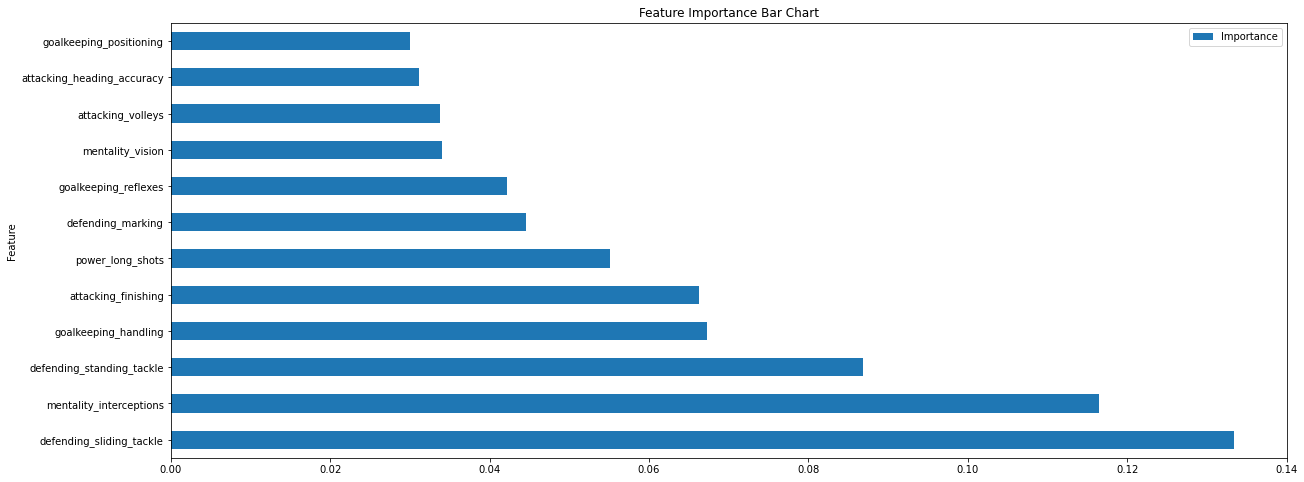

In [168]:
# visualize feature importance
plt.figure(figsize=(20,10))
coef_df[coef_df['Importance'] > 0.03].plot.barh(x='Feature', 
               y ='Importance',
               figsize=(20,8), 
               title='Feature Importances', 
               fontsize=10)
plt.title('Feature Importance Bar Chart')
plt.show()

# Recommender System

## Feature engineering

In [187]:
# prepare data
data = pd.concat([general_data, onehot_data], axis=1)
data = data.drop(['preferred_foot'], axis=1)
data = data.reset_index(drop=True)

In [188]:
# find out all columns we need for pca, clustering and recommender system
remove_columns = ['short_name', 'dob', 'nationality', 'club', 'preferred_foot', 'body_type', 'Position', 'Attack_workrate', 'Defend_workrate', 'Positon_General']
va_columns = list(set(data.columns) - set(remove_columns))
clustering_data = data[va_columns]

In [189]:
# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_data = pd.DataFrame(scaler.fit_transform(clustering_data), columns=clustering_data.columns)

## Building system

In [190]:
# PCA Reduce the dimension to 2 
from sklearn.decomposition import PCA
recommender_pca = PCA(n_components=2)
recommender_data = pd.DataFrame(recommender_pca.fit_transform(scaler_data), columns=['PC1', 'PC2'])

# add name
recommender_data['Name'] = list(data['short_name'])

In [191]:
def recommender_system(name, num_players):
  try:
    cha = list([name])
    num = int(num_players)
  except:
    return 'Check your inputs!'

  length_check = (len(cha) == 1)
  exist_check = (recommender_data['Name'] == name).any()

  if length_check & exist_check:
      PC1 = recommender_data[recommender_data['Name'] == name]['PC1'].values[0]
      PC2 = recommender_data[recommender_data['Name'] == name]['PC2'].values[0]

      result = recommender_data.apply(lambda row: np.sqrt((row.PC1 - PC1)**2 + (row.PC2 - PC2)**2), axis=1).sort_values().iloc[:num+1]
    
    
  else:
    return 'Check your inputs!'
  
  return data.iloc[result.index[1:]][['short_name', 'Position', 'overall', 'value_eur']].rename({'short_name':'Name', 'Position':'Position', 'overall':'Overall Score', 'value_eur':'Value'}, axis='columns').reset_index(drop=True)

## System Testing

In [193]:
recommender_system('L. Messi',5)

,Name,Position,Overall Score,Value
0,Neymar Jr,LW,92,105500000
1,E. Hazard,LW,91,90000000
2,K. Mbappé,ST,89,93500000
3,P. Dybala,CAM,88,76500000
4,Cristiano Ronaldo,ST,93,58500000


In [195]:
recommender_system('Cristiano Ronaldo',5)

,Name,Position,Overall Score,Value
0,A. Griezmann,CF,89,69000000
1,M. Salah,RW,90,80500000
2,L. Modrić,CM,90,45000000
3,Bruno Fernandes,CAM,85,49000000
4,K. Mbappé,ST,89,93500000


In [196]:
recommender_system('J. Oblak',5)

,Name,Position,Overall Score,Value
0,M. ter Stegen,GK,90,67500000
1,Alisson,GK,89,58000000
2,H. Lloris,GK,88,36000000
3,M. Neuer,GK,88,32000000
4,De Gea,GK,89,56000000


In [197]:
recommender_system('V. van Dijk',5)

,Name,Position,Overall Score,Value
0,M. Hummels,CB,87,41000000
1,L. Bonucci,CB,86,28500000
2,A. Laporte,CB,87,56500000
3,Piqué,CB,88,38000000
4,T. Alderweireld,CB,87,41000000


In [198]:
recommender_system('K. De Bruyne',5)

,Name,Position,Overall Score,Value
0,A. Griezmann,CF,89,69000000
1,L. Modrić,CM,90,45000000
2,Cristiano Ronaldo,ST,93,58500000
3,Thiago,CM,87,50000000
4,Bruno Fernandes,CAM,85,49000000


# Clustering

## Choosing best pca for k-means

In [210]:
# define the best pca components
min(len(scaler_data)-1, len(va_columns))

45

In [203]:
clutering_pca = PCA(n_components=45)
clutering_data = pd.DataFrame(clutering_pca.fit_transform(scaler_data))

In [204]:
# account for 100% variance of original data
sum(clutering_pca.explained_variance_ratio_)

1.0000000000000002

Text(0, 0.5, 'Proportion Variance Explained')

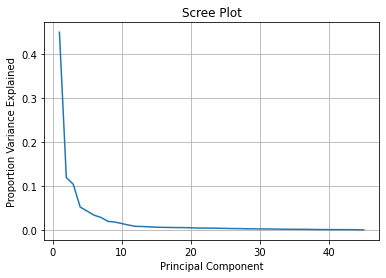

In [205]:
from matplotlib import pyplot as plt
plt.figure()
explained_var = clutering_pca.explained_variance_ratio_
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.grid(True)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

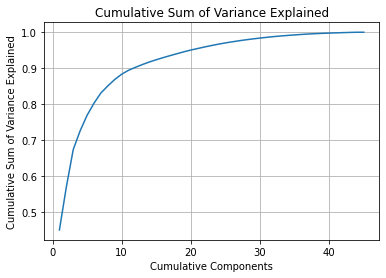

In [206]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.grid(True)
plt.title("Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

## K-Means

In [211]:
# best pca: 30
kmeans_pca = PCA(n_components=30)
kmeans_data = kmeans_pca.fit_transform(scaler_data)

In [212]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def max_silhouette(k):
  score = []
  for i in range(3):
    km = KMeans(n_clusters=k, random_state=int(np.random.randint(100, size=1)))
    pred = km.fit_predict(kmeans_data)
    score.append(silhouette_score(kmeans_data, pred))
  
  return max(score)


In [213]:
result = []
for i in range(2, 7):
  result.append(max_silhouette(i))

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

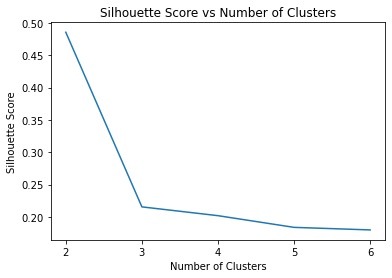

In [214]:
plt.plot(range(2,7), result)
plt.xticks(range(2,7))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

In [215]:
# best k for kmeans is 2

### Best Clustering Result

In [216]:
final_km = KMeans(n_clusters=2)
final_pred = final_km.fit_predict(scaler_data)

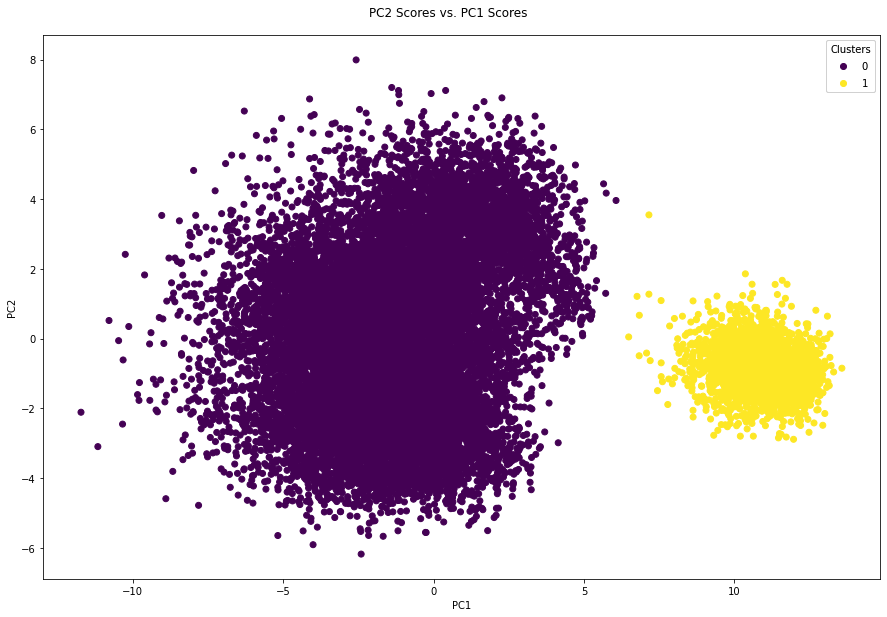

In [217]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
scatter = ax.scatter(recommender_data.PC1, recommender_data.PC2, c=final_pred)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
ax.add_artist(legend)
fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")  
plt.show()